In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bering = pd.read_excel(filepath, sheet_name='Bering-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Bering)
fp.date_time(Bering)

,Extent,Date
0,320266.650,1979-01-01
1,541778.338,1979-02-01
2,638262.988,1979-03-01
3,423025.159,1979-04-01
4,215587.216,1979-05-01
...,...,...
488,317377.493,2023-05-01
489,39601.476,2023-06-01
490,16935.702,2023-07-01
491,1305.744,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bering['Extent'] = scaler.fit_transform(Bering['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 6
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bering['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((476, 12, 1), (476,))

In [8]:
X_train, y_train = X[:384], y[:384]
X_val, y_val = X[384:432], y[384:432]
X_test, y_test = X[432:], y[432:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bering_model_LT6/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
48/48 [==============================] - 12s 180ms/step - loss: 0.1721 - root_mean_squared_error: 0.4148 - val_loss: 0.0511 - val_root_mean_squared_error: 0.2261
Epoch 2/50
48/48 [==============================] - 7s 155ms/step - loss: 0.1355 - root_mean_squared_error: 0.3681 - val_loss: 0.0368 - val_root_mean_squared_error: 0.1917
Epoch 3/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0934 - root_mean_squared_error: 0.3057 - val_loss: 0.0432 - val_root_mean_squared_error: 0.2078
Epoch 4/50
48/48 [==============================] - 1s 14ms/step - loss: 0.0855 - root_mean_squared_error: 0.2924 - val_loss: 0.0414 - val_root_mean_squared_error: 0.2035
Epoch 5/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0801 - root_mean_squared_error: 0.2830 - val_loss: 0.0431 - val_root_mean_squared_error: 0.2076
Epoch 6/50
48/48 [==============================] - 1s 14ms/step - loss: 0.0730 - root_mean_squared_error: 0.2701 - val_loss: 0.0373 - val_roo

48/48 [==============================] - 1s 17ms/step - loss: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1879
Epoch 45/50
48/48 [==============================] - 1s 22ms/step - loss: 0.0111 - root_mean_squared_error: 0.1052 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1770
Epoch 46/50
48/48 [==============================] - 1s 18ms/step - loss: 0.0115 - root_mean_squared_error: 0.1074 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1819
Epoch 47/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0098 - root_mean_squared_error: 0.0988 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1878
Epoch 48/50
48/48 [==============================] - 1s 20ms/step - loss: 0.0100 - root_mean_squared_error: 0.1002 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1869
Epoch 49/50
48/48 [==============================] - 1s 16ms/step - loss: 0.0109 - root_mean_squared_error: 0.1043 - val_loss: 0.0383 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

1.3331732908884684 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

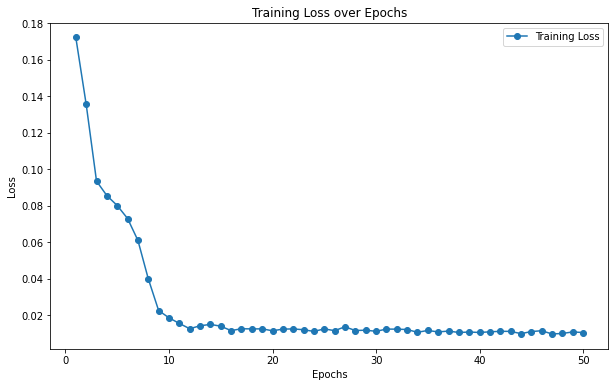

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

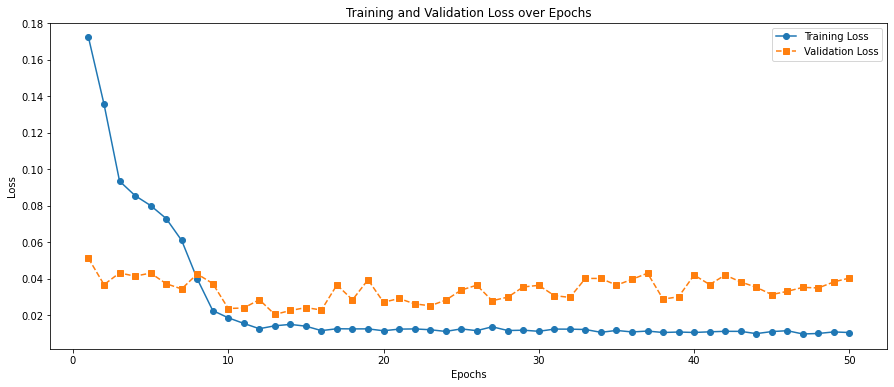

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bering_model_LT6/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 0s/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.117036440352364
MAE : 0.08099421542857638


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,351195.718750,49957.406
1,458292.281250,151973.751
2,488017.281250,466524.938
3,489804.906250,708542.184
4,456823.906250,652598.000
5,383627.500000,414216.785
6,256011.093750,236263.303
7,103701.156250,43422.368
8,41711.367188,2161.744
9,84142.585938,944.181


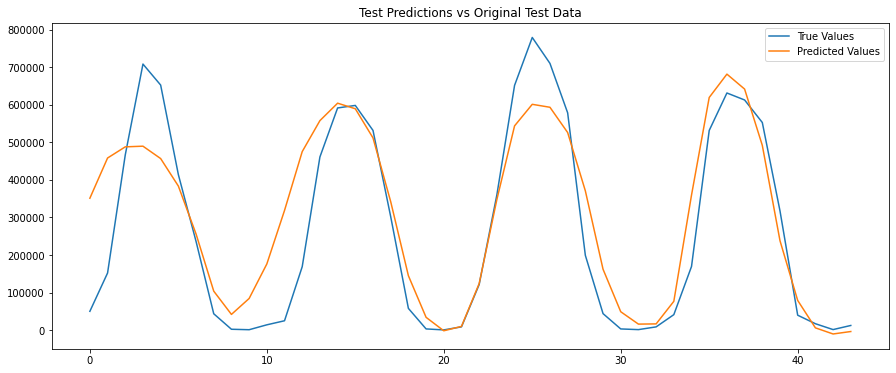

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

15/15 [==============================] - 0s 10ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

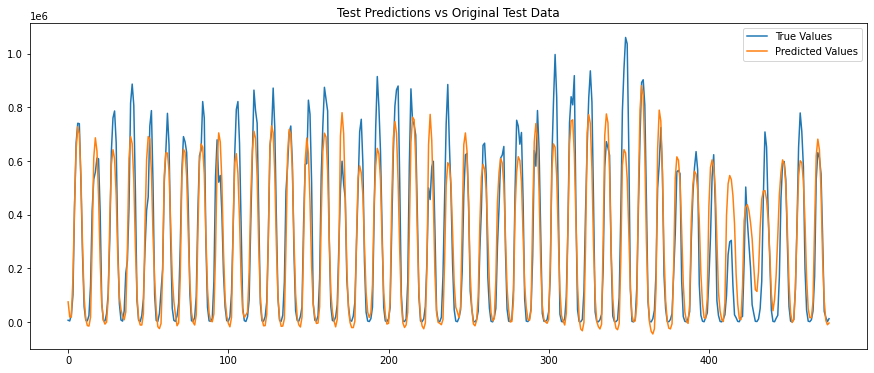

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()